<a href="https://colab.research.google.com/github/SHodapp117/Portfolio-/blob/main/Statsbomb_Spain_Passing_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kloppy
!pip install statsbombpy
!pip install mplsoccer
import pandas as pd
from statsbombpy import sb
from mplsoccer import Pitch
from matplotlib.colors import to_rgba
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.patches import FancyArrowPatch
from mplsoccer.pitch import VerticalPitch
import matplotlib as mpl
from mplsoccer import FontManager
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = 'Palatino Linotype'

In [2]:
sb.competitions()
euro_20 = sb.matches(competition_id=55, season_id=43)

MATCH_id = 3795108
match_events_df = sb.events(match_id=MATCH_id)

match_360_df = pd.read_json('/content/3795108.json')
match_360_df.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3795108,2021-07-02,18:00:00.000,Europe - UEFA Euro,2020,Switzerland,Spain,1,1,available,...,2023-04-27T21:55:08.695971,5,Quarter-finals,Saint-Petersburg Stadium,Michael Oliver,Vladimir Petković,Luis Enrique Martínez García,1.1.0,2,2
1,3788769,2021-06-21,21:00:00.000,Europe - UEFA Euro,2020,Russia,Denmark,1,4,available,...,2023-04-27T22:20:21.686564,3,Group Stage,Parken,Clément Turpin,Stanislav Cherchesov,Kasper Hjulmand,1.1.0,2,2
2,3788766,2021-06-20,18:00:00.000,Europe - UEFA Euro,2020,Italy,Wales,1,0,available,...,2023-04-27T22:22:42.769375,3,Group Stage,Estadio Olímpico,Ovidiu Alin Hațegan,Roberto Mancini,Robert Page,1.1.0,2,2
3,3795220,2021-07-06,21:00:00.000,Europe - UEFA Euro,2020,Italy,Spain,1,1,available,...,2022-08-04T12:00,6,Semi-finals,Wembley Stadium,Felix Brych,Roberto Mancini,Luis Enrique Martínez García,1.1.0,2,2
4,3788761,2021-06-18,15:00:00.000,Europe - UEFA Euro,2020,Sweden,Slovakia,1,0,available,...,2023-04-27T22:28:52.986485,2,Group Stage,Saint-Petersburg Stadium,Daniel Siebert,Jan Olof Andersson,Štefan Tarkovič,1.1.0,2,2


In [5]:
#combine all initial data sources together into one df to parse down based on need
df = pd.merge(left=match_events_df, right=match_360_df, left_on='id', right_on='event_uuid', how='left')

location_xy = df.location.apply(pd.Series)
# Save events locations to a Series with 2 columns location_xy = df_pass.location.apply(pd. Series)
# #Rename columns to x and y
location_xy.columns = ['location_x', 'location_y']

# Drop NaN
location_xy.dropna(inplace=True)

# Add new columns back to the original DataFrame
df[['location_x', 'location_y']] = location_xy

Pass_end_xy = df.pass_end_location.apply(pd.Series)

# #Rename columns to x and y
Pass_end_xy.columns = ['pass_end_location_x', 'pass_end_location_y']

# Drop NaN
Pass_end_xy.dropna(inplace=True)

# Add new columns back to the original DataFrame
df[['pass_end_location_x', 'pass_end_location_y']] = Pass_end_xy

Building out the passing network analysis

In [6]:
#filter df to get only the team we want
spain_df = df[df['team']=='Spain']
spain_df['pass_outcome'].fillna('Good', inplace=True)
spain_df.columns

<ipython-input-6-838924b23ff2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spain_df['pass_outcome'].fillna('Good', inplace=True)


Index(['50_50', 'ball_receipt_outcome', 'ball_recovery_offensive',
       'ball_recovery_recovery_failure', 'block_deflection', 'block_offensive',
       'carry_end_location', 'clearance_aerial_won', 'clearance_body_part',
       'clearance_head', 'clearance_left_foot', 'clearance_right_foot',
       'counterpress', 'dribble_outcome', 'dribble_overrun', 'duel_outcome',
       'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_type', 'foul_won_advantage',
       'foul_won_defensive', 'goalkeeper_body_part', 'goalkeeper_end_location',
       'goalkeeper_outcome', 'goalkeeper_position', 'goalkeeper_technique',
       'goalkeeper_type', 'id', 'index', 'interception_outcome', 'location',
       'match_id', 'minute', 'miscontrol_aerial_won', 'off_camera', 'out',
       'pass_aerial_won', 'pass_angle', 'pass_assisted_shot_id',
       'pass_body_part', 'pass_cross', 'pass_cut_back', 'pass_deflected',
       'pass_end_location', 'pass_goal_assist'

In [9]:
# dictionary for player numbers to match jersey numbers
number_mapping_dict = {
    3477.0: 7,
    6892.0: 4,
    4353.0: 24,
    5211.0: 18,
    6720.0: 22,
    5199.0: 8,
    11748.0: 23,
    5203.0: 5,
    6748.0: 11,
    3957.0: 2,
    30486.0: 26,
    16532.0: 19,
    6766.0: 9,
    6840.0: 6,
    6685.0: 21,
    5208.0: 10,
    6765.0: 16}

# Map player_id to new values
spain_df['player_id'] = spain_df['player_id'].map(number_mapping_dict)

# Player name mapping
name_mapping_dict = {
    'Álvaro Borja Morata Martín': 'Álvaro Morata',
    'Pau Francisco Torres': 'Pau Torres',
    'Aymeric Laporte': 'A. Laporte',
    'Jordi Alba Ramos': 'Jordi Alba',
    'Pablo Sarabia García': 'Sarabia',
    'Jorge Resurrección Merodio': 'Koke',
    'Unai Simón Mendibil': 'Unai Simón',
    'Sergio Busquets i Burgos': 'Sergio Busquets',
    'Ferrán Torres García': 'Ferrán Torres',
    'César Azpilicueta Tanco': 'Azpilicueta',
    'Pedro González López': 'Pedri',
    'Daniel Olmo Carvajal': ' Dani Olmo',
    'Gerard Moreno Balaguero': 'Gerard Moreno',
    'Marcos Llorente Moreno': 'Marcos Llorente',
    'Mikel Oyarzabal Ugarte': 'Oyarzabal',
    'Thiago Alcântara do Nascimento': 'Thiago',
    'Rodrigo Hernández Cascante': 'Rodri' }

# Map player to new values
spain_df['player'] = spain_df['player'].map(name_mapping_dict)

<ipython-input-9-8a2a2cbc82df>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spain_df['player_id'] = spain_df['player_id'].map(number_mapping_dict)
<ipython-input-9-8a2a2cbc82df>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spain_df['player'] = spain_df['player'].map(name_mapping_dict)


In [10]:
# Create the 'recipient' column by shifting the 'playerId' column by -1
spain_df['passer'] = spain_df['player_id']
spain_df['recipient'] = spain_df['player_id'].shift(-1)

# Filter for only passes that connected with another spain player
passes = spain_df[spain_df['type'] == 'Pass']
successful_passes = passes[passes['pass_outcome'] == 'Good']

#find the first subsititution and filter the successful dataframe to be less than that minute
substitution_minutes = spain_df.loc[spain_df['type'] == 'Substitution', 'minute']
substitution_minutes = substitution_minutes.to_list()

successful_passes = successful_passes[successful_passes['minute'] <= substitution_minutes[0]]

#now we need to find the average locations and counts of the passes
average_locations = successful_passes.groupby('passer').agg({'location_x':['mean'],'pass_angle':['mean'],'location_y':['mean','count']})
average_locations.columns = ['x','angle','y','count']

#now we need to find the number of passes between each player
pass_between = successful_passes.groupby(['passer','recipient']).id.count().reset_index()
pass_between.rename({'id':'pass_count'},axis='columns',inplace=True)

#merge the average location dataframe. We need to merge on the passer first then the recipient
pass_between = pass_between.merge(average_locations, left_on='passer',right_index=True)
pass_between = pass_between.merge(average_locations, left_on='recipient',right_index=True,suffixes=['', '_end'])

#set minimum threshold of combinationsI have seen a range of 2-5 as Spain is a pass heavy team I opted for 4
pass_between = pass_between[pass_between['pass_count'] > 3]

#Build a normilization for passes for secondary analysis
max_pass_count = pass_between['pass_count'].max()

# Normalize 'pass_count' column
pass_between['normalized_pass_count'] = pass_between['pass_count'] / max_pass_count

<ipython-input-10-12d24da63ab8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spain_df['passer'] = spain_df['player_id']
<ipython-input-10-12d24da63ab8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spain_df['recipient'] = spain_df['player_id'].shift(-1)


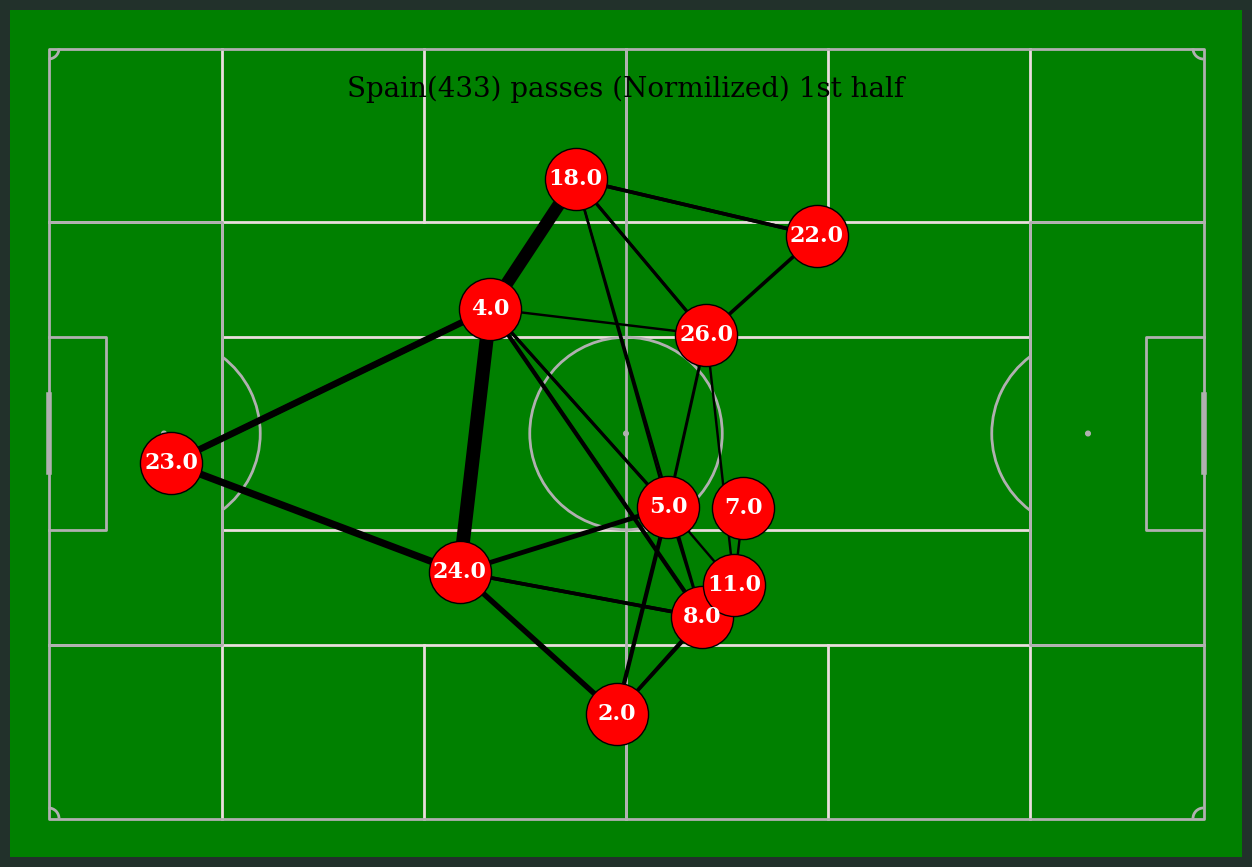

In [17]:
# standard weighted
pass_between['width'] = (pass_between['pass_count'] / pass_between['pass_count'].max()* 10)

# Replace 'average_locs_and_count' with your dataframe containing count data.
average_locations['marker_size'] = (average_locations['count']
                                         / average_locations['count'].max()* 10 )


MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('black'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

pitch = Pitch(pitch_color='green', corner_arcs=True, positional=True, positional_color='#eadddd', shade_color='#f2f2f2')


fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
annotation = ax.annotate('Spain(433) passes in 1st half', (60, 5), fontsize=20, ha='center')
fig.set_facecolor("#22312b")


pass_lines = pitch.lines(pass_between.x, pass_between.y,
                         pass_between.x_end, pass_between.y_end, lw=pass_between.width,
                         color='black', zorder=1, ax=ax)

pass_nodes = pitch.scatter(average_locations.x, average_locations.y,
                           s=2000,
                           color='red', edgecolors='black', linewidth=1, alpha=1, ax=ax)

for index, row in average_locations.iterrows():
    pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=16, weight='bold', ax=ax)





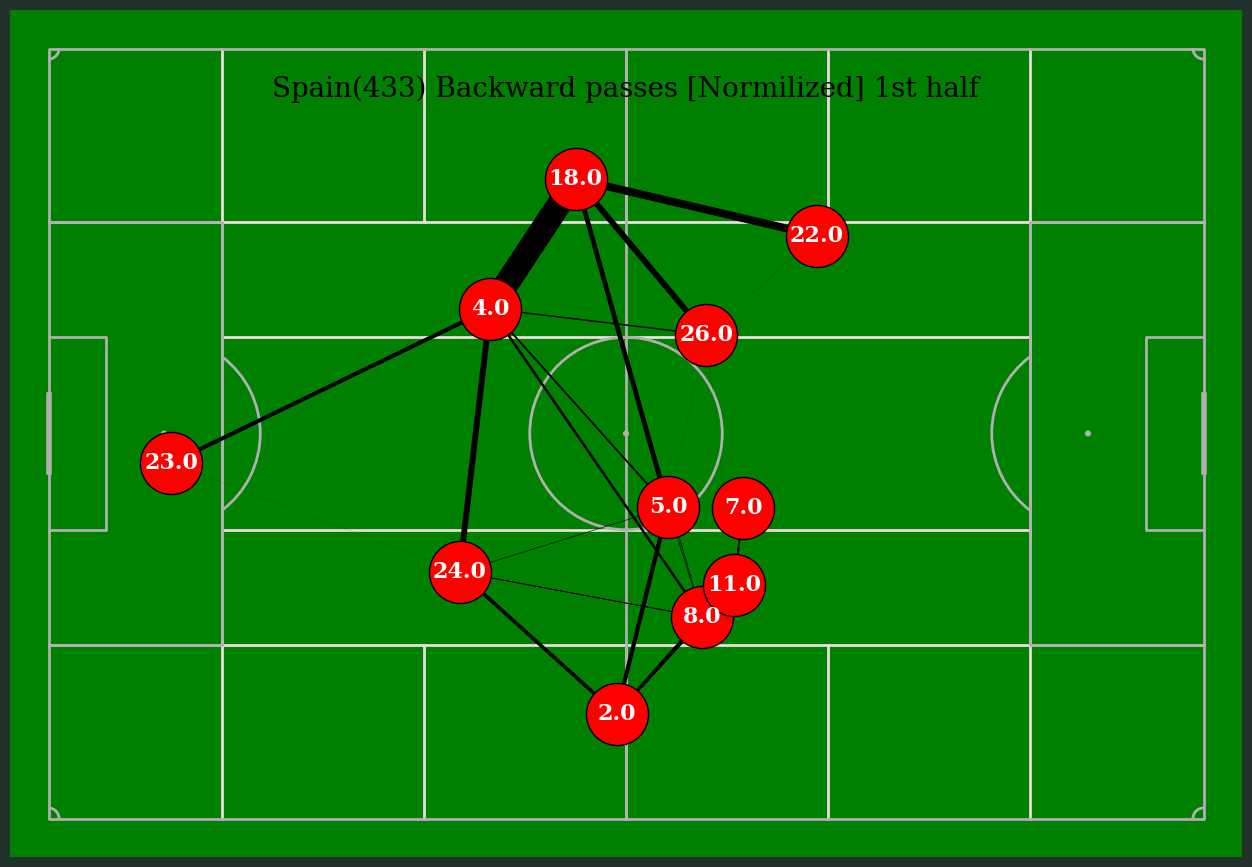

In [18]:
# backwords passing weighted.
pass_between['width'] =  (pass_between['normalized_pass_count'] * pass_between['angle']) * (1 - abs(pass_between['angle'] + 1)) * 10

# Replace 'average_locs_and_count' with your dataframe containing count data.
average_locations['marker_size'] = (average_locations['count']
                                         / average_locations['count'].max()* 10 )

MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('black'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.angle / pass_between.angle.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

pitch = Pitch(pitch_color='green', corner_arcs=True, positional=True, positional_color='#eadddd', shade_color='#f2f2f2')


fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
annotation = ax.annotate('Spain(433) Backward passes [Normilized] 1st half', (60, 5), fontsize=20, ha='center')
fig.set_facecolor("#22312b")

pass_lines = pitch.lines(pass_between.x, pass_between.y,
                         pass_between.x_end, pass_between.y_end, lw=pass_between.width,
                         color='black', zorder=1, ax=ax)

pass_nodes = pitch.scatter(average_locations.x, average_locations.y,
                           s=2000,
                           color='red', edgecolors='black', linewidth=1, alpha=1, ax=ax)


for index, row in average_locations.iterrows():
    pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=16, weight='bold', ax=ax)

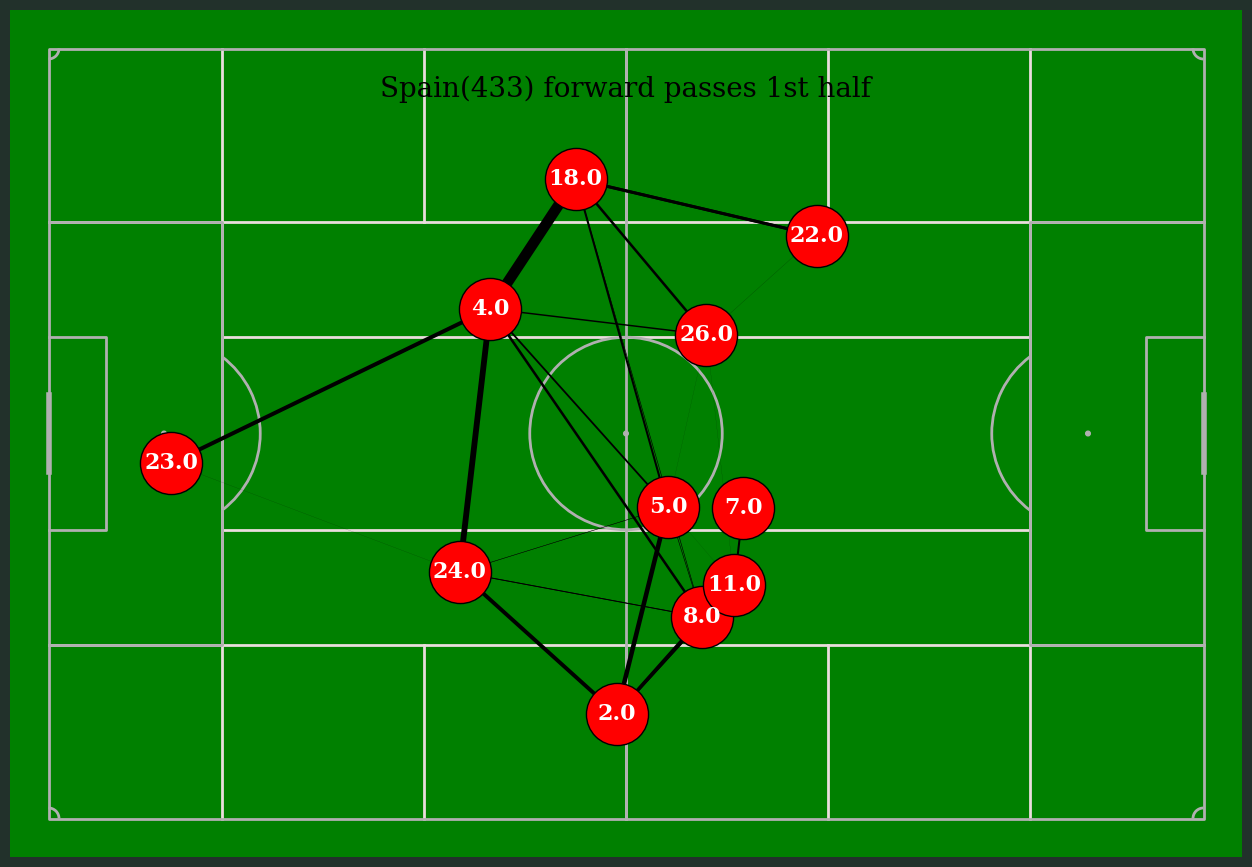

In [19]:
#forward weighted passes
pass_between['width'] =  (pass_between['normalized_pass_count'] * pass_between['angle']) * (1 - abs(pass_between['angle'] - 1)) * 10

MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('black'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.normalized_pass_count / pass_between.normalized_pass_count.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

#setting details per the pitch function
pitch = Pitch(pitch_color='green', corner_arcs=True, positional=True, positional_color='#eadddd', shade_color='#f2f2f2')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)

annotation = ax.annotate('Spain(433) forward passes 1st half', (60, 5), fontsize=20, ha='center')
fig.set_facecolor("#22312b")

pass_lines = pitch.lines(pass_between.x, pass_between.y,
                         pass_between.x_end, pass_between.y_end, lw=pass_between.width,
                         color='black', zorder=1, ax=ax)

pass_nodes = pitch.scatter(average_locations.x, average_locations.y,
                           s=2000,
                           color='red', edgecolors='black', linewidth=1, alpha=1, ax=ax)


for index, row in average_locations.iterrows():
    pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=16, weight='bold', ax=ax)

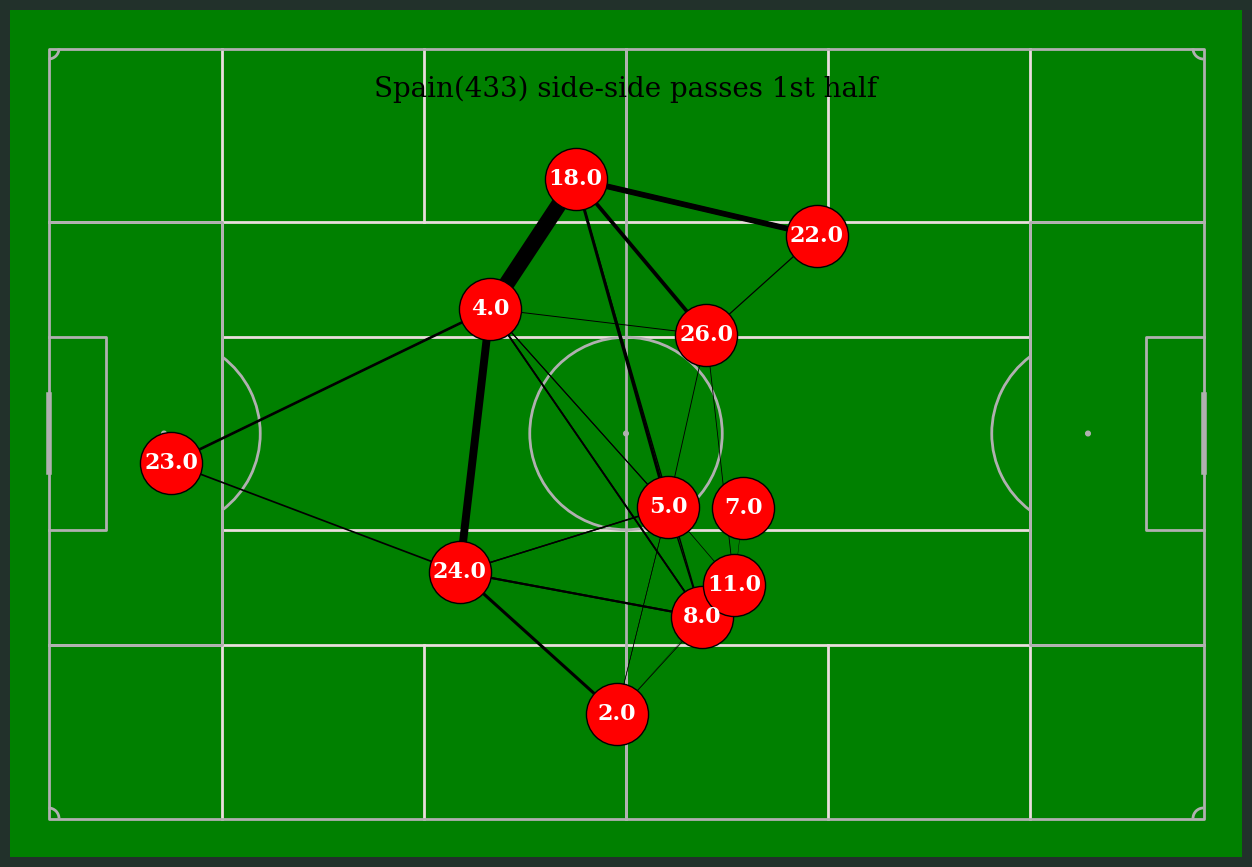

In [14]:
#side to side passes
pass_between['width'] =  (pass_between['pass_count'] * pass_between['angle']) * (1 - abs(pass_between['angle']))
# Replace 'average_locs_and_count' with your dataframe containing count data.
average_locations['marker_size'] = (average_locations['count']
                                         / average_locations['count'].max()* 10 )

MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('black'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.normalized_pass_count / pass_between.normalized_pass_count.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

pitch = Pitch(pitch_color='green', corner_arcs=True, positional=True, positional_color='#eadddd', shade_color='#f2f2f2')


fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)

annotation = ax.annotate('Spain(433) side-side passes 1st half', (60, 5), fontsize=20, ha='center')

fig.set_facecolor("#22312b")

pass_lines = pitch.lines(pass_between.x, pass_between.y,
                         pass_between.x_end, pass_between.y_end, lw=pass_between.width,
                         color='black', zorder=1, ax=ax)

pass_nodes = pitch.scatter(average_locations.x, average_locations.y,
                           s=2000,
                           color='red', edgecolors='black', linewidth=1, alpha=1, ax=ax)


for index, row in average_locations.iterrows():
    pitch.annotate(row.name, xy=(row.x, row.y), c='white', va='center',
                   ha='center', size=16, weight='bold', ax=ax)
